In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
def getData(file):
	data = pd.read_csv(file, header=None)
	x = data.iloc[:,1:].to_numpy()
	y = data.iloc[:,0].to_numpy()
	y = np.array([int(i) for i in y])
	return x, y
 
def accuracy(y, pred):
  acc = 0
  for i in range(len(y)):
    if pred[i] == y[i]:
      acc += 1
  acc = acc/len(y)
  return acc

def ConfusionMatrix(y, pred, file):
  labels = np.unique(y)
  cm = confusion_matrix(y, pred)

  fig = plt.figure(figsize=(8,8))
  ax = fig.gca()
  _ = sns.heatmap(cm,annot=True,cmap="Blues",xticklabels=labels,yticklabels=labels,fmt='g')
  ax.set_xlabel("Actual Class")
  ax.set_ylabel("Predicted Class")
  plt.title("Confusion Matrix",y=1.08)
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')
  plt.savefig(file)
  plt.show()
  plt.close()

In [3]:
x_train, y_train = getData('/content/drive/MyDrive/Colab Notebooks/train.csv')
x_test, y_test = getData('/content/drive/MyDrive/Colab Notebooks/public_test.csv')
private_xtest, private_ytest = getData('/content/drive/MyDrive/Colab Notebooks/private.csv')
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(private_xtest.shape, private_ytest.shape)

(19376, 2304) (19376,)
(6459, 2304) (6459,)
(19157, 2304) (19157,)


In [4]:
x_train = x_train.reshape(x_train.shape[0], 1, 48, 48)
x_test = x_test.reshape(x_test.shape[0], 1, 48, 48)

tx_train = torch.FloatTensor(x_train.tolist()).cuda()
ty_train = torch.LongTensor(y_train.tolist()).cuda()

tx_test = torch.FloatTensor(x_test.tolist()).cuda()
ty_test = torch.LongTensor(y_test.tolist()).cuda()

print(tx_train.size())
print(ty_train.size())
print(tx_test.size())
print(ty_test.size())

torch.Size([19376, 1, 48, 48])
torch.Size([19376])
torch.Size([6459, 1, 48, 48])
torch.Size([6459])


In [5]:
class NeuralNet(nn.Module):
	def __init__(self, n, r):
		super(NeuralNet, self).__init__()
		self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), stride=3, padding=0)
		self.bn1 = nn.BatchNorm2d(64)
		self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
		self.conv2 = nn.Conv2d(64, 128, kernel_size=(2,2), stride=2, padding=0)
		self.bn2 = nn.BatchNorm2d(128)
		self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
		self.fc1 = nn.Linear(512, 256)
		self.bn3 = nn.BatchNorm1d(256)
		self.fc2 = nn.Linear(256, r)
		self.bn4 = nn.BatchNorm1d(r)

	def forward(self, x):
		x = self.pool1(F.relu(self.bn1(self.conv1(x))))
		x = self.pool2(F.relu(self.bn2(self.conv2(x))))
		x = x.view(x.shape[0],-1)
		x = F.relu(self.bn3(self.fc1(x)))
		x = self.bn4(self.fc2(x))
		return F.log_softmax(x, dim=1)

	def predict(self, x):
		num_batches = int(x.shape[0]/100)
		pred = np.array([0.])
		for i in range(num_batches):
			x_batch = x[i*100:(i+1)*100]
			pred = np.concatenate((pred, torch.max(self.forward(x_batch).data, 1)[1].cpu().numpy()))
		pred = np.concatenate((pred, torch.max(self.forward(x[num_batches*100:x.shape[0]]), 1)[1].cpu().numpy()))
		return pred[1:]

	def fit(self, x, y, r, optimizer, loss_func):
		num_batches = int(x.shape[0]/r)
		converged = False
		epochs = 0
		prevloss = 0
		error = 0
		while not converged:
			for i in range(num_batches):
				x_batch = x[i*r:(i+1)*r]
				y_batch = y[i*r:(i+1)*r]
				x_var = Variable(x_batch)
				y_var = Variable(y_batch)
				optimizer.zero_grad()
				out = self.forward(x_var)
				loss = loss_func(out, y_var)
				loss.backward()
				optimizer.step()
			error = abs(prevloss - loss.data)
			prevloss = loss.data
			print('Epoch: {} - Loss: {:.6f} - Error: {:.6f}'.format(epochs, loss.data, error))
			epochs += 1
			del loss
			if epochs > 10 and error < 1e-5 or epochs > 500:
				converged = True

In [6]:
model = NeuralNet(x_train.shape[1], 7)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
print(model)

NeuralNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (bn4): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [7]:
start = time.time()
model.fit(tx_train, ty_train, 100, optimizer, loss_func)
end = time.time()
print("Training Time = ", (end-start))

Epoch: 0 - Loss: 1.619448 - Error: 1.619448
Epoch: 1 - Loss: 1.503026 - Error: 0.116422
Epoch: 2 - Loss: 1.422067 - Error: 0.080958
Epoch: 3 - Loss: 1.345869 - Error: 0.076198
Epoch: 4 - Loss: 1.301904 - Error: 0.043965
Epoch: 5 - Loss: 1.218962 - Error: 0.082942
Epoch: 6 - Loss: 1.099113 - Error: 0.119849
Epoch: 7 - Loss: 1.007733 - Error: 0.091380
Epoch: 8 - Loss: 1.069181 - Error: 0.061448
Epoch: 9 - Loss: 0.960976 - Error: 0.108204
Epoch: 10 - Loss: 0.878302 - Error: 0.082675
Epoch: 11 - Loss: 0.800694 - Error: 0.077608
Epoch: 12 - Loss: 0.726827 - Error: 0.073867
Epoch: 13 - Loss: 0.594047 - Error: 0.132780
Epoch: 14 - Loss: 0.565302 - Error: 0.028745
Epoch: 15 - Loss: 0.540790 - Error: 0.024512
Epoch: 16 - Loss: 0.344822 - Error: 0.195968
Epoch: 17 - Loss: 0.399417 - Error: 0.054595
Epoch: 18 - Loss: 0.364941 - Error: 0.034476
Epoch: 19 - Loss: 0.380939 - Error: 0.015998
Epoch: 20 - Loss: 0.335393 - Error: 0.045546
Epoch: 21 - Loss: 0.176938 - Error: 0.158455
Epoch: 22 - Loss: 0.

Train Accuracy =  0.9977291494632535
Macro F1 Score  =  0.997957205540329


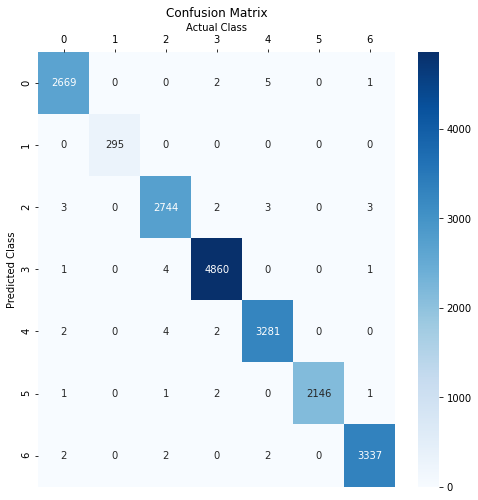

In [9]:
train_pred = model.predict(tx_train)
train_acc = accuracy(y_train, train_pred)
print("Train Accuracy = ", train_acc)
print("Macro F1 Score  = ", f1_score(y_train, train_pred, average='macro'))
ConfusionMatrix(y_train, train_pred, 'Q1ctrain.png')

Test Accuracy =  0.40625483821024927
Macro F1 Score  =  0.385919478691743


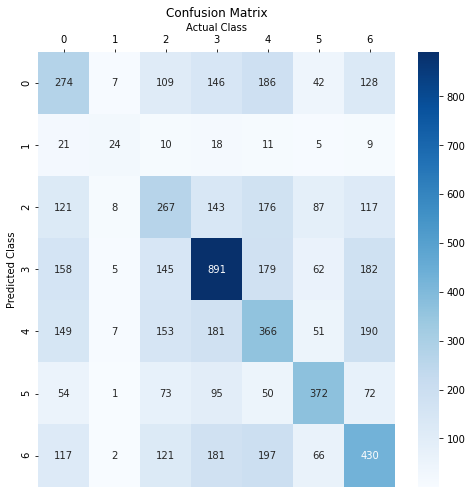

In [10]:
test_pred = model.predict(tx_test)
test_acc = accuracy(y_test, test_pred)
print("Test Accuracy = ", test_acc)
print("Macro F1 Score  = ", f1_score(y_test, test_pred, average='macro'))
ConfusionMatrix(y_test, test_pred, 'Q1ctest.png')

In [11]:
! python3 '/content/drive/MyDrive/Colab Notebooks/Q1c.py' '/content/drive/MyDrive/Colab Notebooks/train.csv' '/content/drive/MyDrive/Colab Notebooks/private.csv' '/content/drive/MyDrive/Colab Notebooks/A4/Q1c.txt'

In [12]:
Q1c = torch.load('/content/drive/MyDrive/Colab Notebooks/A4/Q1c')

Train Accuracy =  0.9977807597027251
Macro F1 Score  =  0.9978324143136154


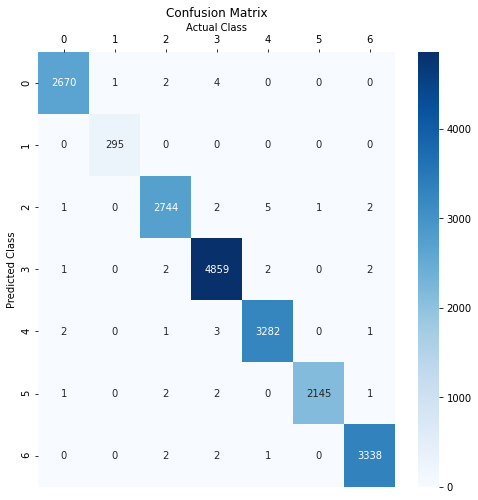

In [13]:
train_pred = Q1c.predict(tx_train)
train_acc = accuracy(y_train, train_pred)
print("Train Accuracy = ", train_acc)
print("Macro F1 Score  = ", f1_score(y_train, train_pred, average='macro'))
ConfusionMatrix(y_train, train_pred, 'Q1ctrain.png')

Test Accuracy =  0.3994426381792847
Macro F1 Score  =  0.37409188789797704


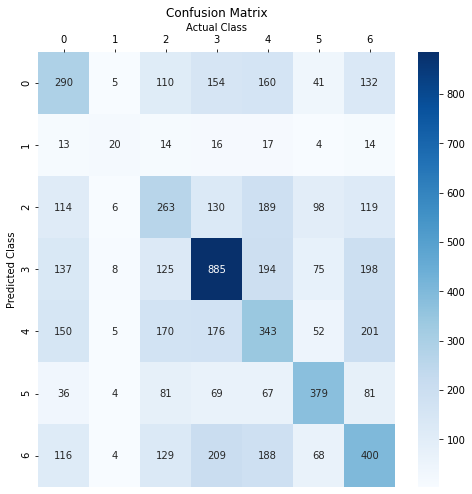

In [14]:
test_pred = Q1c.predict(tx_test)
test_acc = accuracy(y_test, test_pred)
print("Test Accuracy = ", test_acc)
print("Macro F1 Score  = ", f1_score(y_test, test_pred, average='macro'))
ConfusionMatrix(y_test, test_pred, 'Q1ctest.png')